In [56]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style="whitegrid")
import pandas as pd
from tqdm.notebook import tqdm

In [69]:
processors = 4
experiments = 10
maximum = 1024 * 100000
intervals = 10

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)


[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[16, 2560000, 5120000, 7680000, 10240000, 12800000, 15360000, 17920000, 20480000, 23040000]


In [70]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [72]:
experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    label="gregor-mac"
    log = f"result-{label}-{experiment}.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        os.system (f"mpiexec -n {processors} python count-click.py --n {n} --max_number 10 --find 8 --label gregor-mac"
                   f"| tee -a {log}")

    lines = Shell.grep("csv,Result:", log)
    # print(lines)
    values = []
    times = []

    for line in lines.splitlines():
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 16                   10 | 0/10 [00:00<?, ?it/s]

Benchmark 2560000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 5120000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 7680000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 12800000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 15360000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 17920000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 20480000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 23040000             10 | 0/10 [00:00<?, ?it/s]

In [73]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
16,0.005,0.001,0.000,0.000,0.000,0.001,0.000,0.001,0.001,0.000
2560000,2.509,2.753,3.103,3.389,3.415,3.397,3.117,3.363,3.149,3.922
5120000,5.086,5.843,6.776,6.964,6.689,7.309,6.699,6.963,7.483,6.179
7680000,8.200,9.357,10.152,10.459,10.778,12.191,10.964,12.386,10.676,9.517
10240000,11.114,11.781,13.750,15.003,14.089,16.220,13.062,15.536,14.395,14.272
12800000,14.456,14.622,15.720,17.704,20.284,17.602,16.982,18.689,18.335,17.283
15360000,18.609,17.453,19.827,19.855,22.719,21.523,22.332,23.541,20.260,21.027
17920000,22.165,22.192,23.205,24.136,25.253,25.285,23.365,26.113,26.877,25.460
20480000,23.842,24.056,28.558,27.062,30.923,28.231,28.554,29.864,29.753,27.830


<AxesSubplot:xlabel='Size'>

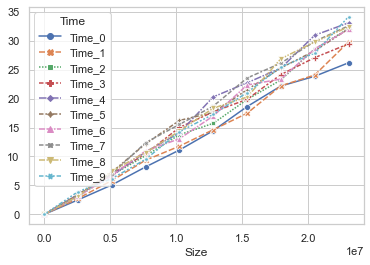

In [74]:
sns.lineplot(data=df, markers=True)

In [75]:
plt.show()

In [76]:
plt.savefig(f'benchmark-{label}.png')


<Figure size 432x288 with 0 Axes>

In [77]:
plt.savefig(f'benchmark-{label}.pdf')

<Figure size 432x288 with 0 Axes>

In [78]:
plt.show()

In [79]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
16,0.005
16,0.001
16,0.000
16,0.000
16,0.000
...,...
23040000,32.016
23040000,31.949
23040000,32.555


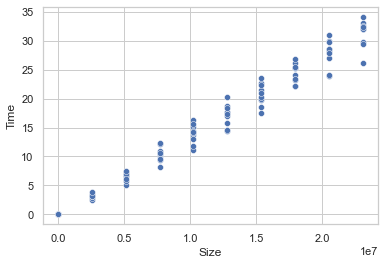

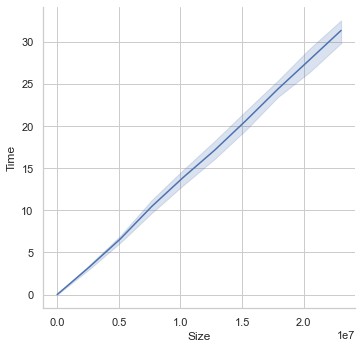

In [80]:
sns.scatterplot(data=dfs, x="Size", y="Time")
sns.relplot(x="Size", y="Time", kind="line", data=dfs);